# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir("/content/drive/MyDrive/mlproject")
!ls

 all_authors.tsv
 all_publications.tsv
 dbscan_15_2_all_mini_l6v2.pickle
 dbscan_15_2_all_minilm_l3v2.pickle
 dbscan_15_2_all_mpnet_basev2.pickle
 dbscan_17_2_all_mini_l6v2.pickle
 dbscan_17_2_all_minilm_l3v2.pickle
 dbscan_17_2_all_mpnet_basev2.pickle
 dbscan_20_2_all_mini_l6v2.pickle
 dbscan_20_2_all_minilm_l3v2.pickle
 dbscan_20_2_all_mpnet_basev2.pickle
 dbscan_25_2_all_mini_l6v2.pickle
 dbscan_25_2_all_minilm_l3v2.pickle
 dbscan_25_2_all_mpnet_basev2.pickle
'DBSCAN and GM.ipynb'
 dbscan_manhattan_150_2_all_minilm_l3v2.pickle
 dbscan_manhattan_160_2_all_mini_l6v2.pickle
 dbscan_manhattan_180_2_all_mini_l6v2.pickle
 dbscan_manhattan_180_2_all_minilm_l3v2.pickle
 dbscan_manhattan_250_2_all_mpnet_basev2.pickle
 dbscan_manhattan_280_2_all_mpnet_basev2.pickle
 gm_1001_all_mini_l6v2_.pickle
 gm_1001_all_mini_l6v2_random_init.pickle
 gm_1001_all_minilm_l3v2_.pickle
 gm_1001_all_mpnet_basev2_.pickle
 gm_2000_all_mpnet_basev2.pickle
 gm_800_all_mini_l6v2.pickle
 gm_800_all_mini_l6v2_random_

In [ ]:
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.7 MB 42.7 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [ ]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 5.7 MB/s 
     |████████████████████████████████| 5.8 MB 64.2 MB/s 
     |████████████████████████████████| 1.3 MB 62.9 MB/s 
     |████████████████████████████████| 182 kB 77.9 MB/s 
     |████████████████████████████████| 7.6 MB 61.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=1c5415a4baab059e6853bed9769569871775c46a221982ff40b3ba1ab2157f02
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


In [ ]:
#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

import string

from multiprocessing import  Pool
import numpy as np
import pandas as pd

from sentence_transformers import SentenceTransformer
from sentence_transformers import util
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.mixture import GaussianMixture
import pickle


In [ ]:
#read data from .tsv files
import pandas as pd
df_all_authors = pd.read_csv("all_authors.tsv", sep='\t', encoding= 'ISO-8859-1')
df_all_publications = pd.read_csv("all_publications.tsv", sep='\t')
df_selected_author_publications = pd.read_csv("selected_author_publications_information.tsv", sep='\t')
df_selected_publication_citations = pd.read_csv("selected_publication_citations_information.tsv", sep='\t')

In [ ]:
# Drop duplicates
df_all_publications.drop_duplicates(inplace=True)
df_selected_publication_citations.drop_duplicates(inplace=True)

# Drop NA's
#
print(df_all_publications.isna().sum())
print(df_selected_publication_citations.isna().sum())
df_selected_publication_citations.drop(['citation_sentence_cited'], axis=1, inplace=True)
df_all_publications.dropna(inplace=True)
print(df_all_publications.isna().sum())

paper_id                         0
paper_dblp_key                   0
paper_title                      0
paper_filtered_title             0
paper_published_date             0
paper_published_conference       0
paper_gscholar_url               0
paper_dblp_url                   0
paper_abstract                2529
dtype: int64
citing_paper_id                   0
cited_paper_id                    0
citation_title                    0
citation_filtered_title           0
citation_sentence_before       3843
citation_sentence_cited          25
citation_sentence_after        3391
citation_position (section)       0
dtype: int64
paper_id                      0
paper_dblp_key                0
paper_title                   0
paper_filtered_title          0
paper_published_date          0
paper_published_conference    0
paper_gscholar_url            0
paper_dblp_url                0
paper_abstract                0
dtype: int64


In [ ]:
titles    = []
abstracts = []
confs      = []
citeds    = []
cited_confs = []
cited_abs = []
paper_ids = []

for cited_idx, title in enumerate(df_selected_publication_citations['citation_filtered_title']):
    paper_id_found = False
    cited_paper_id = df_selected_publication_citations['cited_paper_id'].iloc[cited_idx]   
    paper_id = df_selected_publication_citations["citing_paper_id"].iloc[cited_idx]

    # All publications has not contain paper information for paper_id = 5835
    try:
        citeds.append(title)
        titles.append(df_all_publications['paper_title'].iloc[df_all_publications.index[df_all_publications['paper_id'] == paper_id].tolist()[0]])
        abstracts.append(df_all_publications['paper_abstract'].iloc[df_all_publications.index[df_all_publications['paper_id'] == paper_id].tolist()[0]])
        confs.append(df_all_publications['paper_published_conference'].iloc[df_all_publications.index[df_all_publications['paper_id'] == paper_id].tolist()[0]])
        paper_id_found = True
        cited_confs.append(df_all_publications['paper_published_conference'].iloc[df_all_publications.index[df_all_publications['paper_id'] == cited_paper_id].tolist()[0]])
        cited_abs.append(df_all_publications['paper_abstract'].iloc[df_all_publications.index[df_all_publications['paper_id'] == cited_paper_id].tolist()[0]])
        
        paper_ids.append(paper_id)
    except:
        if paper_id_found:
            titles.pop()
            abstracts.pop()
            confs.pop()
            citeds.pop()
            
        continue

In [ ]:
headers = ['paper_id', 'paper_title', 'paper_abstract', 'paper_published_conference', 'cited_paper_title', 'cited_paper_published_conference', 'cited_paper_abstract']
df = pd.DataFrame(list(zip(paper_ids, titles, abstracts, confs, citeds, cited_confs, cited_abs)),
               columns = headers)

df['paper_abstract'] = df['paper_abstract'].astype(str).map(lambda x: x.lstrip('[').rstrip(']'))
df['cited_paper_abstract'] = df['cited_paper_abstract'].astype(str).map(lambda x: x.lstrip('[').rstrip(']'))
df = df.drop_duplicates()


In [ ]:
df_selected_author_publications["author_id"] = df_selected_author_publications["author"] 
df_selected_author_publications["paper_id"] = df_selected_author_publications["publication"] 

In [ ]:
author_clustering = pd.merge(df_selected_author_publications, df, on="paper_id", how="inner")
author_clustering = pd.merge(author_clustering, df_all_authors, on="author_id", how="inner")

In [ ]:
author_clustering_df = author_clustering[["paper_title","paper_abstract",  "paper_published_conference", "cited_paper_title", "cited_paper_published_conference", "cited_paper_abstract" ]]
author_clustering_df["author_name"] = author_clustering["author_fname"] + author_clustering["author_lname"]

<ipython-input-12-b28e255da358>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  author_clustering_df["author_name"] = author_clustering["author_fname"] + author_clustering["author_lname"]


In [ ]:
punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

print(len(stopwords))

350


In [ ]:
parser = spacy.load("en_core_web_sm")
parser.max_length = 7000000

def call_tokenizer(df):
    df["text"] = df["text"].apply(spacy_tokenizer)
    #df["paper_title"] = df["paper_title"].apply(spacy_tokenizer)
    #df["processed_cited_paper_abstract"] = df["cited_paper_abstract"].apply(spacy_tokenizer)
    return df

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [ ]:
def parallelize_dataframe(df, func, n_cores=4):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [ ]:
df = author_clustering_df

In [ ]:
df["text"] = df["paper_title"] + df["paper_abstract"] + df["cited_paper_title"] + df["cited_paper_abstract"] 

<ipython-input-17-f0e782865944>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text"] = df["paper_title"] + df["paper_abstract"] + df["cited_paper_title"] + df["cited_paper_abstract"]


In [ ]:
list_paper_published_conference = df['paper_published_conference']
dict_paper_published_conference = dict([(y,x+1) for x,y in enumerate(sorted(set(list_paper_published_conference)))])

In [ ]:
list_cited_paper_published_conference = df['cited_paper_published_conference']
dict_cited_paper_published_conference = dict([(y,x+1) for x,y in enumerate(sorted(set(list_cited_paper_published_conference)))])

In [ ]:
df.reset_index(drop=True, inplace=True)
df.head()

,paper_title,paper_abstract,paper_published_conference,cited_paper_title,cited_paper_published_conference,cited_paper_abstract,author_name,text
0,Sim-to-Real Transfer with Neural-Augmented Rob...,Despite the recent successes of deep reinforce...,CoRL,neural machine translation by jointly learning...,EC-Web,Alternating least squares (ALS) is a powerful ...,AaronCourville,Sim-to-Real Transfer with Neural-Augmented Rob...
1,Mutual Information Neural Estimation.,We argue that the estimation of mutual informa...,ICML,learning to parse and translate improves neura...,Electronic Markets,Both private and public sector organizations t...,AaronCourville,Mutual Information Neural Estimation.We argue ...
2,Towards Text Generation with Adversarially Lea...,Recent progress in deep generative models has ...,NeurIPS,show attend and tell neural image caption gene...,IEEE Trans. Pattern Anal. Mach. Intell.,Abstract-The success of machine learning algo...,AaronCourville,Towards Text Generation with Adversarially Lea...
3,Towards Text Generation with Adversarially Lea...,Recent progress in deep generative models has ...,NeurIPS,neural machine translation by jointly learning...,EC-Web,Alternating least squares (ALS) is a powerful ...,AaronCourville,Towards Text Generation with Adversarially Lea...
4,Multiresolution Recurrent Neural Networks: An ...,We introduce a new class of models called mult...,AAAI,improved techniques for training gans,MoDELS,OATAO is an open access repository that collec...,AaronCourville,Multiresolution Recurrent Neural Networks: An ...


In [ ]:
for i in range(df["paper_title"].count()):
  df["paper_published_conference"][i] = dict_paper_published_conference[df["paper_published_conference"][i]]
  df["cited_paper_published_conference"][i] = dict_cited_paper_published_conference[df["cited_paper_published_conference"][i]]

<ipython-input-21-59a4385af72b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["paper_published_conference"][i] = dict_paper_published_conference[df["paper_published_conference"][i]]
<ipython-input-21-59a4385af72b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cited_paper_published_conference"][i] = dict_cited_paper_published_conference[df["cited_paper_published_conference"][i]]


In [ ]:
df.head()

,paper_title,paper_abstract,paper_published_conference,cited_paper_title,cited_paper_published_conference,cited_paper_abstract,author_name,text
0,Sim-to-Real Transfer with Neural-Augmented Rob...,Despite the recent successes of deep reinforce...,188,neural machine translation by jointly learning...,167,Alternating least squares (ALS) is a powerful ...,AaronCourville,Sim-to-Real Transfer with Neural-Augmented Rob...
1,Mutual Information Neural Estimation.,We argue that the estimation of mutual informa...,441,learning to parse and translate improves neura...,203,Both private and public sector organizations t...,AaronCourville,Mutual Information Neural Estimation.We argue ...
2,Towards Text Generation with Adversarially Lea...,Recent progress in deep generative models has ...,794,show attend and tell neural image caption gene...,324,Abstract-The success of machine learning algo...,AaronCourville,Towards Text Generation with Adversarially Lea...
3,Towards Text Generation with Adversarially Lea...,Recent progress in deep generative models has ...,794,neural machine translation by jointly learning...,167,Alternating least squares (ALS) is a powerful ...,AaronCourville,Towards Text Generation with Adversarially Lea...
4,Multiresolution Recurrent Neural Networks: An ...,We introduce a new class of models called mult...,5,improved techniques for training gans,464,OATAO is an open access repository that collec...,AaronCourville,Multiresolution Recurrent Neural Networks: An ...


In [ ]:
df.drop(columns = 'cited_paper_title', axis = 1, inplace= True)
df.drop(columns = 'cited_paper_abstract', axis = 1, inplace= True)
df.drop(columns = 'paper_title', axis = 1, inplace= True)
df.drop(columns = 'paper_abstract', axis = 1, inplace= True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
df['text'] = df.groupby(["author_name"])['text'].transform(lambda x: ','.join(x))
df['paper_published_conference'] = df.groupby(["author_name"])['paper_published_conference'].transform(lambda x: ','.join(str(x)))
df['cited_paper_published_conference'] = df.groupby(["author_name"])['cited_paper_published_conference'].transform(lambda x: ','.join(str(x)))
df = df[["author_name", "text" ]].drop_duplicates()

<ipython-input-24-b23c56f3ef36>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df.groupby(["author_name"])['text'].transform(lambda x: ','.join(x))
<ipython-input-24-b23c56f3ef36>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['paper_published_conference'] = df.groupby(["author_name"])['paper_published_conference'].transform(lambda x: ','.join(str(x)))
<ipython-input-24-b23c56f3ef36>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
%time df = parallelize_dataframe(df=df, func=call_tokenizer, n_cores=50)

Process ForkPoolWorker-4:
Process ForkPoolWorker-43:
Process ForkPoolWorker-42:
Process ForkPoolWorker-7:
Process ForkPoolWorker-5:
Process ForkPoolWorker-23:
Process ForkPoolWorker-46:
Process ForkPoolWorker-2:
Process ForkPoolWorker-50:
Process ForkPoolWorker-45:
Process ForkPoolWorker-47:
Process ForkPoolWorker-48:
Process ForkPoolWorker-16:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-44:
Process ForkPoolWorker-32:
Process ForkPoolWorker-55:
Process ForkPoolWorker-28:
Process ForkPoolWorker-22:
Process ForkPoolWorker-37:
Process ForkPoolWorker-27:
Process ForkPoolWorker-40:
Process ForkPoolWorker-51:
Process ForkPoolWorker-19:
Process ForkPoolWorker-30:
Process ForkPoolWorker-11:
Process ForkPoolWorker-21:
Process ForkPoolWorker-26:
Process ForkPoolWorker-35:
Process ForkPoolWorker-29:
Process ForkPoolWorker-20:
Process ForkPoolWor

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/magics/execution.py", line 1310, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 1, in <module>
  File "<ipython-input-15-da35e84010d7>", line 4, in parallelize_dataframe
    df = pd.concat(pool.map(func, df_split))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 364, in map
    return self._map_async(func, iterable, mapstar, chunksize).get()
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 765, in get
    self.wait(timeout)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 762, in wait
    self._event.wait(timeout)
  File "/usr/lib/python3.8/threading.py", line 558, in wait
    signaled = self._cond.wait(timeout)
  File "/usr/lib/python3.8/threading.py", line 302, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/

Process ForkPoolWorker-87:
Process ForkPoolWorker-74:


KeyboardInterrupt: ignored

Process ForkPoolWorker-59:
Process ForkPoolWorker-60:
Process ForkPoolWorker-77:
Process ForkPoolWorker-93:
Process ForkPoolWorker-66:
Process ForkPoolWorker-88:
Process ForkPoolWorker-65:
Process ForkPoolWorker-92:
Process ForkPoolWorker-62:
Process ForkPoolWorker-64:
Process ForkPoolWorker-94:
Process ForkPoolWorker-95:
Process ForkPoolWorker-69:
Process ForkPoolWorker-83:
Process ForkPoolWorker-89:
Process ForkPoolWorker-96:
Process ForkPoolWorker-91:
Process ForkPoolWorker-84:
Process ForkPoolWorker-79:
Process ForkPoolWorker-82:
Process ForkPoolWorker-76:
Process ForkPoolWorker-90:
Process ForkPoolWorker-75:


In [ ]:
train_set = df.sample(frac = 0.7)
test_set  = df.drop(train_set.index)

# Check the ratio
print(df.shape)
print(train_set.shape[0] / df.shape[0])
print(test_set.shape[0] / df.shape[0])

df.head(5)
train_set.head(5)

(486, 4)
0.6995884773662552
0.3004115226337449


,author_name,paper_published_conference,cited_paper_published_conference,text
302,BipinIndurkhya,"8,0,9,6, , , , ,1,0,2,5,\n,8,0,9,7, , , , , ,8...","8,0,9,6, , , , ,3,0,6,\n,8,0,9,7, , , , ,4,0,2...",Time Series Classification Using Multi-Channel...
284,JudithMasthoff,"7,6,8,0, , , , ,1,0,0,3,\n,7,6,8,1, , , , ,1,0...","7,6,8,0, , , , ,4,7,4,\n,7,6,8,1, , , , ,3,9,6...",Domain adaptation methods for improving lab-to...
335,YuanXuan,"8,8,5,0, , , , ,1,0,4,5,\n,8,8,5,1, , , , ,1,0...","8,8,5,0, , , , ,5,0,9,\n,8,8,5,1, , , , ,5,3,1...",On the Power of Massive Text Data.The real-wor...
466,RoseCatherine,"1,1,0,6,7, , , , , ,7,1,4,\n,1,1,0,6,8, , , , ...","1,1,0,6,7, , , , ,3,1,8,\n,1,1,0,6,8, , , , ,1...",Enhancing Access to Online Education: Quality ...
376,PanagiotisBouros,"9,5,2,3, , , , ,1,4,8,\n,9,5,2,4, , , , ,1,4,8...","9,5,2,3, , , , ,1,9,2,\n,9,5,2,4, , , , ,1,2,6...",Soft clustering criterion functions for partit...


In [ ]:
train_set.to_csv("author_train_set.tsv", sep='\t')
test_set.to_csv("author_test_set.tsv", sep='\t')

In [ ]:
loaded_train_set = pd.read_csv("author_train_set.tsv", sep='\t')
loaded_test_set = pd.read_csv("author_test_set.tsv", sep='\t')

# TEXT TO VEC

In [ ]:
model_1 = SentenceTransformer('all-MiniLM-L6-v2')




#For other pre-trained models, please check link below:
#https://www.sbert.net/docs/pretrained_models.html

# For other columns
#title_embedding = model.encode(loaded_train_set["paper_title"])
#conf_embedding = model.encode(loaded_train_set["paper_published_conference"])
#cited_title_embedding = model.encode(loaded_train_set["cited_paper_title"])
#cited_conf_embedding = model.encode(loaded_train_set["cited_paper_published_conference"])
#cited_abs_embedding = model.encode(loaded_train_set["cited_paper_abstract"])

# For paper abstracts

# Model : all-MiniLM-L6-v2
embedding_train_all_mini_l6v2 = model_1.encode(loaded_train_set["text"])
print(embedding_train_all_mini_l6v2.shape)



Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

(340, 384)


In [ ]:
model_1 = SentenceTransformer('all-MiniLM-L6-v2')

# Model : all-MiniLM-L6-v2
embedding_test_all_mini_l6v2 = model_1.encode(loaded_test_set["text"])
print(embedding_test_all_mini_l6v2.shape)



(146, 384)


In [ ]:
#define scaler
scaler = StandardScaler()

scaled_train_set_all_mini_l6v2=pd.DataFrame(scaler.fit_transform(embedding_train_all_mini_l6v2))
print(scaled_train_set_all_mini_l6v2.shape)


(340, 384)


In [ ]:
#define scaler
scaler = StandardScaler()
scaled_test_set_all_mini_l6v2=pd.DataFrame(scaler.fit_transform(embedding_test_all_mini_l6v2))
print(scaled_test_set_all_mini_l6v2.shape)



(146, 384)


# Model : all-MiniLM-L6-v2

In [ ]:
pca_all_mini_l6v2 = PCA()
pca_result_all_mini_l6v2 = pca_all_mini_l6v2.fit_transform((scaled_train_set_all_mini_l6v2))
print('Cumulative variance explained by principal components: {:.2%}'.format(np.sum(pca_all_mini_l6v2.explained_variance_ratio_)))
n_pcs= pca_all_mini_l6v2.components_.shape[0]
print("Number of principal components : {}". format(n_pcs))
print("Shape of principal components : {}". format(pca_all_mini_l6v2.components_.shape))

Cumulative variance explained by principal components: 100.00%
Number of principal components : 340
Shape of principal components : (340, 384)


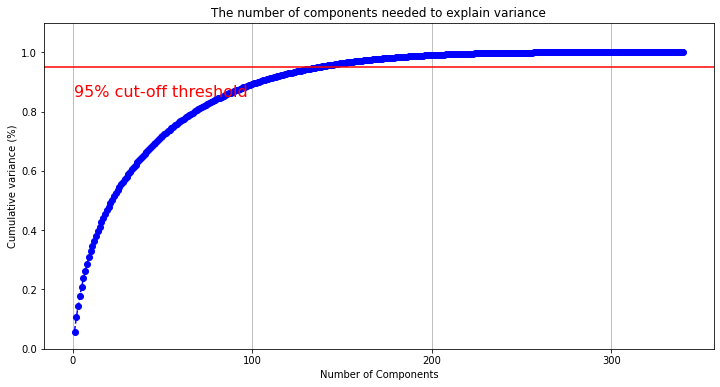

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, n_pcs+1, step=1)
y = np.cumsum(pca_all_mini_l6v2.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, n_pcs, step=100)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [ ]:
pca_all_mini_l6v2 = PCA(n_components=0.95)
principalComponents_all_mini_l6v2 = pca_all_mini_l6v2.fit_transform(scaled_train_set_all_mini_l6v2)
principalComponents_all_mini_l6v2 = pd.DataFrame(principalComponents_all_mini_l6v2)
principalComponents_all_mini_l6v2.shape

(340, 137)

In [ ]:
principalComponents_all_mini_l6v2.head()

,0,1,2,3,4,5,6,7,8,9,...,129,130,131,132,133,134,135,136,paper_published_conference,cited_paper_published_conference
0,0.575002,10.524407,0.301092,1.192644,0.198521,3.746403,-0.408463,-2.142268,2.802839,0.826867,...,0.730202,-0.219813,-0.595078,0.288643,-1.676143,-0.392207,-0.113741,-0.244254,"8,0,9,6, , , , ,1,0,2,5,\n,8,0,9,7, , , , , ,8...","8,0,9,6, , , , ,3,0,6,\n,8,0,9,7, , , , ,4,0,2..."
1,4.690017,6.644600,0.927854,-3.441043,2.277154,5.563810,0.520967,2.038677,5.884834,-3.157258,...,-0.374063,0.055289,-0.290877,0.265378,0.491622,0.311474,-0.432683,0.105496,"7,6,8,0, , , , ,1,0,0,3,\n,7,6,8,1, , , , ,1,0...","7,6,8,0, , , , ,4,7,4,\n,7,6,8,1, , , , ,3,9,6..."
2,-6.762167,2.406389,2.916189,4.157254,5.144635,-0.898698,-0.970526,-4.957253,0.660802,-2.329446,...,-0.236586,-0.213155,0.366226,-0.883180,-0.032295,0.880257,-0.046836,-0.230664,"8,8,5,0, , , , ,1,0,4,5,\n,8,8,5,1, , , , ,1,0...","8,8,5,0, , , , ,5,0,9,\n,8,8,5,1, , , , ,5,3,1..."
3,1.378115,6.326318,1.422500,-0.680277,-3.357397,0.233933,4.774204,-1.052497,-2.471173,-0.746462,...,-0.213708,-0.825270,-1.455055,0.614849,0.746302,-0.414357,0.416586,0.961216,"1,1,0,6,7, , , , , ,7,1,4,\n,1,1,0,6,8, , , , ...","1,1,0,6,7, , , , ,3,1,8,\n,1,1,0,6,8, , , , ,1..."
4,-4.033063,0.994351,0.188252,3.062799,0.550527,1.783143,0.893666,1.143638,2.365368,-1.316307,...,-1.412037,1.658133,-1.449986,0.805399,0.870679,-1.712394,-0.569249,-0.740547,"9,5,2,3, , , , ,1,4,8,\n,9,5,2,4, , , , ,1,4,8...","9,5,2,3, , , , ,1,9,2,\n,9,5,2,4, , , , ,1,2,6..."


In [ ]:
principalComponents_all_mini_l6v2.to_csv("author_train_set_final_all-MiniLM-L6-v2.tsv", sep='\t')
principalComponents_all_mini_l6v2 = pd.read_csv("author_train_set_final_all-MiniLM-L6-v2.tsv", sep='\t')
principalComponents_all_mini_l6v2.drop(columns = 'Unnamed: 0', axis = 1, inplace= True)
principalComponents_all_mini_l6v2.shape

(340, 139)

In [ ]:
principalComponents_all_mini_l6v2_test = pca_all_mini_l6v2.transform(scaled_test_set_all_mini_l6v2)
principalComponents_all_mini_l6v2_test = pd.DataFrame(principalComponents_all_mini_l6v2_test)
principalComponents_all_mini_l6v2_test["paper_published_conference"] = loaded_test_set["paper_published_conference"]
principalComponents_all_mini_l6v2_test["cited_paper_published_conference"] = loaded_test_set["cited_paper_published_conference"]
principalComponents_all_mini_l6v2_test.to_csv("author_test_set_final_all-MiniLM-L6-v2.tsv", sep='\t')
principalComponents_all_mini_l6v2_test = pd.read_csv("author_test_set_final_all-MiniLM-L6-v2.tsv", sep='\t')
principalComponents_all_mini_l6v2_test.drop(columns = 'Unnamed: 0', axis = 1, inplace= True)
principalComponents_all_mini_l6v2_test.shape

(146, 139)

## Clustering Authors

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = np.arange(2, 800, 50)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(principalComponents_all_mini_l6v2)
    kmeanModel.fit(principalComponents_all_mini_l6v2)
  
    distortions.append(sum(np.min(cdist(principalComponents_all_mini_l6v2, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / principalComponents_all_mini_l6v2.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(principalComponents_all_mini_l6v2, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / principalComponents_all_mini_l6v2.shape[0]
    mapping2[k] = kmeanModel.inertia_

In [ ]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [ ]:
for key, val in mapping2.items():
    print(f'{key} : {val}')


plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [ ]:
gmm_all_mini_l6v2_1 = GaussianMixture(n_components=50, covariance_type='spherical', random_state=0, max_iter=1000).fit(principalComponents_all_mini_l6v2)
fitted_1 = gmm_all_mini_l6v2_1.predict(principalComponents_all_mini_l6v2)
labels_1 = gmm_all_mini_l6v2_1.predict(principalComponents_all_mini_l6v2_test)
print("calinski harabasz score of model on train data: ", metrics.calinski_harabasz_score(principalComponents_all_mini_l6v2,fitted_1 ))
print("silhouette score of model on train data: " , metrics.silhouette_score(principalComponents_all_mini_l6v2, fitted_1, metric='euclidean'))

In [ ]:
plt.figure(figsize=(14, 7))
plt.scatter(principalComponents_all_mini_l6v2.iloc[:, 0], principalComponents_all_mini_l6v2.iloc[:, 1], c=fitted_1 , s=200, cmap='viridis', linewidths=5)


In [ ]:
print("calinski harabasz score of model on train data: ", metrics.calinski_harabasz_score(principalComponents_all_mini_l6v2_test,labels_1 ))
print("silhouette score of model on train data: " , metrics.silhouette_score(principalComponents_all_mini_l6v2_test, labels_1 , metric='euclidean'))


In [ ]:
plt.figure(figsize=(14, 7))
plt.scatter(principalComponents_all_mini_l6v2_test.iloc[:, 0], principalComponents_all_mini_l6v2_test.iloc[:, 1], c=labels_1 , s=200, cmap='viridis', linewidths=5)


In [ ]:
with open('author_clustering.pickle', 'wb') as f:
    pickle.dump(gmm_all_mini_l6v2_1, f)